In [86]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

import numpy as np
import scipy
import cv2

In [87]:
IMAGE_FILE = '../data/examples/lion-gray.jpg'

BLOCK_SIZE = 8

def BLOCK(x, y):
	return np.s_[x : x + BLOCK_SIZE, y : y + BLOCK_SIZE]

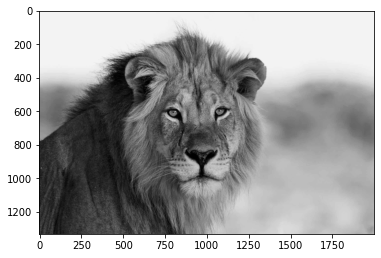

In [88]:
plt.rcParams['figure.figsize'] = [6, 6]

image = imread(IMAGE_FILE)

plt.figure()
plt.imshow(image, cmap = 'gray')

In [89]:
def pad(value, multiple = BLOCK_SIZE):
	return int(multiple * np.ceil(value / multiple))

print('original:', image.shape)
imsize = tuple(map(pad, image.shape))
print('padded:', imsize)

# Pad image with 0 on bottom and right borders
im = np.pad(np.array(image), [
	(0, imsize[0] - image.shape[0]), 
	(0, imsize[1] - image.shape[1])
])

# All dimensions are divisible by BLOCK_SIZE
assert all(map(lambda a: a % BLOCK_SIZE == 0, imsize))

original: (1333, 2000)
padded: (1336, 2000)


In [90]:
def DCT_2D(a):
	return scipy.fftpack.dct(
			scipy.fftpack.dct(a, axis = 0, norm = 'ortho'),
		axis = 1, norm = 'ortho'
	)

def IDCT_2D(a):
    return scipy.fftpack.idct(
			scipy.fftpack.idct(a, axis = 0, norm = 'ortho'),
		axis = 1, norm = 'ortho'
	)

In [91]:

dct = np.zeros(imsize)

# Apply 8x8 block DCT
for i in np.r_[:imsize[0] : BLOCK_SIZE]:
	for j in np.r_[:imsize[1] : BLOCK_SIZE]:
		dct[BLOCK(i, j)] = DCT_2D(im[BLOCK(i, j)])


Text(0.5, 1.0, '8x8 DCT block at position 400')

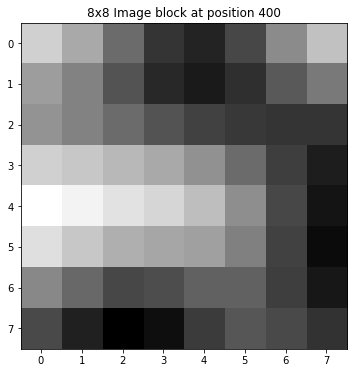

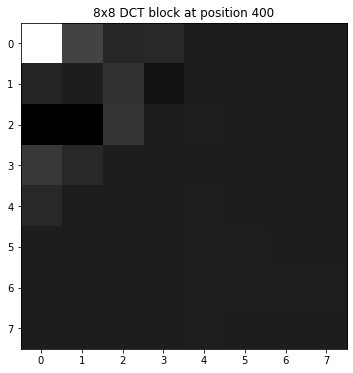

In [92]:
pos = 400

plt.figure()
plt.imshow(image[BLOCK(pos, pos)], cmap = 'gray')
plt.title(f'{BLOCK_SIZE}x{BLOCK_SIZE} Image block at position {pos}')

plt.figure()
plt.imshow(dct[BLOCK(pos, pos)], cmap = 'gray')
plt.title(f'{BLOCK_SIZE}x{BLOCK_SIZE} DCT block at position {pos}')

In [93]:
# Quantize dct coefficients

# JPEG ISO Standard matrix
quantization_matrix = np.array([
	[ 16,  11,  10,  16,  24,  40,  51,  61],
	[ 12,  12,  14,  19,  26,  58,  60,  55],
	[ 14,  13,  16,  24,  40,  57,  69,  56],
	[ 14,  17,  22,  29,  51,  87,  80,  62],
	[ 18,  22,  37,  56,  68, 109, 103,  77],
	[ 24,  35,  55,  64,  81, 104, 113,  92],
	[ 49,  64,  78,  87, 103, 121, 120, 101],
	[ 72,  92,  95,  98, 112, 100, 103,  99]
])

dct_q = np.zeros(imsize, dtype = int)

# Apply 8x8 block quantization
for i in np.r_[:imsize[0] : BLOCK_SIZE]:
	for j in np.r_[:imsize[1] : BLOCK_SIZE]:

		div = dct[BLOCK(i, j)] / quantization_matrix
		dct_q[BLOCK(i, j)] = np.around(div, 0).astype(int)

nonzeros = np.count_nonzero(dct_q)
nonzeros_og = np.count_nonzero(dct)

dim = imsize[0] * imsize[1]
compression_ratio = nonzeros_og / nonzeros

print(f'Total Coefficients: {dim}')
print(f'Initially Nonzero : {nonzeros_og}')
print(f'*Quantized Nonzero: {nonzeros}')

print(f'\nCompression ratio: ~{round(compression_ratio, 3)}x')
print(f'Resulting size: ~{round((1 / compression_ratio) * 100, 3)}%')

Total Coefficients: 2672000
Initially Nonzero : 1216513
*Quantized Nonzero: 199615

Compression ratio: ~6.094x
Resulting size: ~16.409%


Text(0.5, 1.0, 'Quantized 8x8 DCTs')

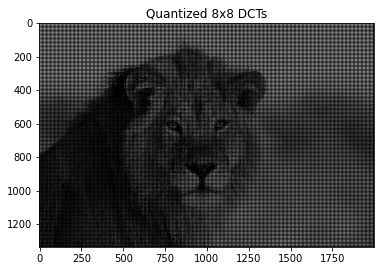

In [94]:
plt.figure()
plt.imshow(dct_q, cmap = 'gray', vmax = np.max(dct_q) * 0.05, vmin = 0)
plt.title(f"Quantized {BLOCK_SIZE}x{BLOCK_SIZE} DCTs")

Text(0.5, 1.0, 'Comparison between original and DCT block quantized images')

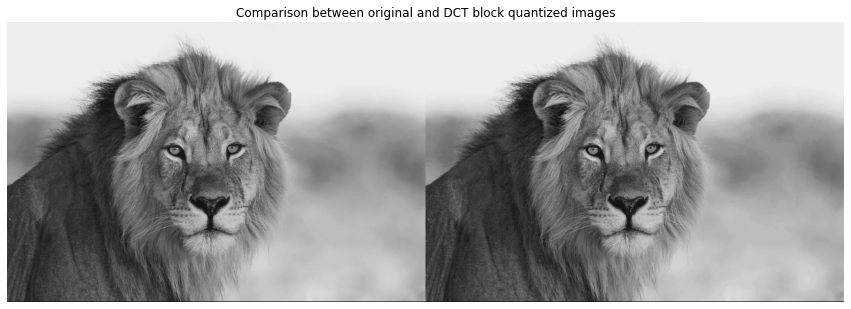

In [95]:

re_dct = np.zeros(imsize)

# Reverse DCT on blocks
for i in np.r_[:imsize[0] : BLOCK_SIZE]:
	for j in np.r_[:imsize[1] : BLOCK_SIZE]:

		reconstruct = dct_q[BLOCK(i, j)] * quantization_matrix
		re_dct[BLOCK(i, j)] = IDCT_2D(reconstruct)

plt.figure(figsize = (15, 15))
plt.imshow(np.hstack((im, re_dct)), cmap = 'gray')
plt.axis('off')
plt.title('Comparison between original and DCT block quantized images')

In [96]:
def MSE(A, B):
	deviation = A - B
	square = np.square(deviation)
	mse = np.mean(square)
	return mse

def RMSE(A, B):
	deviation = A - B
	square = np.square(deviation)
	mean = np.mean(square)
	rmse = np.sqrt(mean)
	return rmse

def PSNR(MSE):
	A = 20 * np.log10(255)
	B = 10 * np.log10(MSE)
	return A - B

mse = MSE(im, re_dct)
print(f'Mean-Squared Error: {mse} (RMSE: ~{round(np.sqrt(mse), 6)})')
print(f'(Smaller means better reconstruction quality)')

psnr = PSNR(mse)
print(f'\nPeak Signal-to-Noise Ratio: {psnr}')
print(f'(Bigger means better reconstruction quality)')

print(f'\nCompression Ratio: {compression_ratio}')
print(f'(Bigger means more thoroughly compressed image)')

Mean-Squared Error: 3.0756254835826518 (RMSE: ~1.753746)
(Smaller means better reconstruction quality)

Peak Signal-to-Noise Ratio: 43.25146910205337
(Bigger means better reconstruction quality)

Compression Ratio: 6.094296520802545
(Bigger means more thoroughly compressed image)
